In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
acceleration = pd.read_csv("acceleration.csv")

In [3]:
acceleration

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2),Absolute acceleration (m/s^2)
0,0.000000,0.000000,0.000000,-0.000000,0.000000
1,0.004974,-0.018037,0.028188,-0.211176,0.213811
2,0.009888,0.014396,-0.010963,-0.157506,0.158542
3,0.014832,-0.013366,-0.027011,0.205908,0.208102
4,0.019775,-0.056252,-0.061009,0.474857,0.482054
5,0.024750,-0.006186,-0.051663,0.578125,0.580462
6,0.029694,-0.055948,-0.018643,0.610325,0.613167
7,0.034637,-0.065307,-0.056422,0.523445,0.530512
8,0.039612,-0.113466,-0.040389,0.544990,0.558139
9,0.044586,-0.124701,-0.098915,0.635875,0.655493


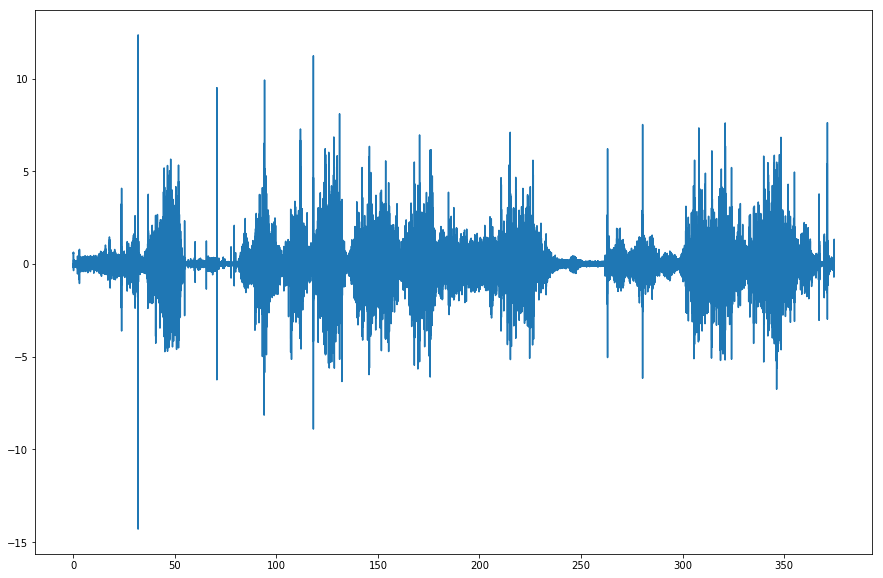

In [4]:
plt.figure(figsize=(15, 10))
plt.plot(acceleration["Time (s)"], acceleration["Linear Acceleration z (m/s^2)"], )

In [5]:
vehicle = pd.read_csv("vehicle-translated.csv")
vehicle_start_time = datetime.datetime.fromisoformat(vehicle["Time [s]"][0]).timestamp()
vehicle_times = [
    datetime.datetime.fromisoformat(vt).timestamp()-vehicle_start_time
    for vt in vehicle["Time [s]"]]
vehicle

,Time [s],Computed Engine Load,Engine RPM,Speed,Air throughput (MAF Sensor),Absolute Engine Load,Relative throttle position,Relative gas pedal position,Unnamed: 8
0,2019-10-31 21:04:01.095,15.686275,902.25,0.0,4.41,17.647058,1.960784,0.0,NaN
1,2019-10-31 21:04:07.470,15.686275,902.25,0.0,4.41,17.647058,1.960784,0.0,NaN
2,2019-10-31 21:04:18.196,16.470589,887.75,0.0,3.97,16.862745,1.568627,0.0,NaN
3,2019-10-31 21:04:24.471,16.470589,887.75,0.0,3.97,17.647058,1.960784,0.0,NaN
4,2019-10-31 21:04:35.114,19.215687,739.00,0.0,5.06,17.254902,1.568627,0.0,NaN
5,2019-10-31 21:04:41.541,19.215687,739.00,0.0,5.06,17.647058,1.960784,0.0,NaN
6,2019-10-31 21:04:52.147,21.568628,752.00,0.0,4.64,17.254902,1.568627,0.0,NaN
7,2019-10-31 21:04:58.472,21.568628,752.00,0.0,4.64,15.294118,1.960784,0.0,NaN
8,2019-10-31 21:05:09.069,15.686275,741.50,0.0,2.95,17.254902,1.568627,0.0,NaN
9,2019-10-31 21:05:15.468,15.686275,741.50,0.0,2.95,12.941176,1.568627,0.0,NaN


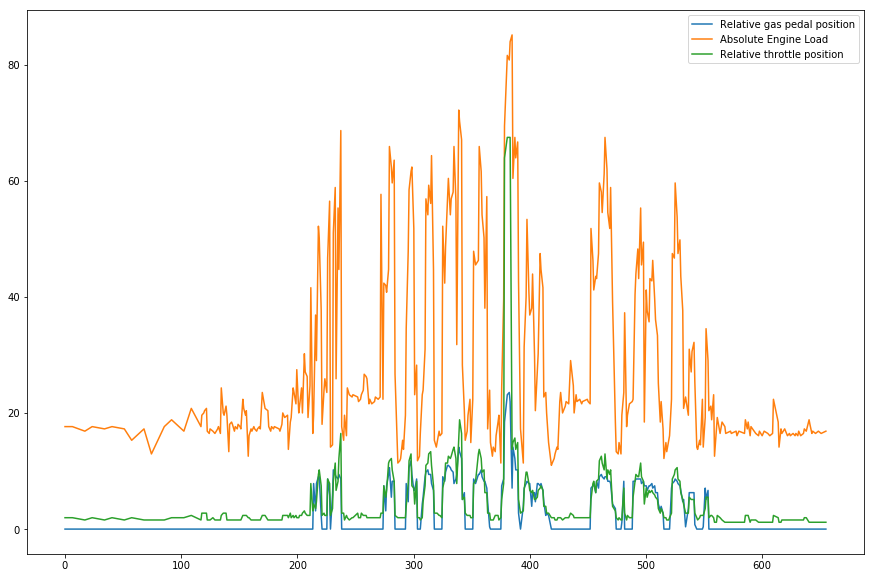

In [6]:
plt.figure(figsize=(15, 10))
#plt.plot(vehicle_times, vehicle["Speed"])
plt.plot(vehicle_times, vehicle["Relative gas pedal position"])
plt.plot(vehicle_times, vehicle["Absolute Engine Load"])
plt.plot(vehicle_times, vehicle["Relative throttle position"])
plt.legend()

In [7]:
import gpxpy

with open("gps-trace.gpx", "r") as infile:
    gpx = gpxpy.parse(infile)

track, = gpx.tracks
seg, = track.segments
gps = seg.points

In [8]:
first_pt = gps[0]
lat_to_dist = 1e3 * first_pt.distance_2d(type(first_pt)(longitude=first_pt.longitude+1e-3, latitude=first_pt.latitude))
lon_to_dist = 1e3 * first_pt.distance_2d(type(first_pt)(longitude=first_pt.longitude, latitude=first_pt.latitude+1e-3))

first_pt

GPXTrackPoint(40.1065306, -88.2494373, elevation=200.555, time=datetime.datetime(2019, 11, 1, 2, 6, 51, tzinfo=SimpleTZ("Z")), horizontal_dilution=16.08)

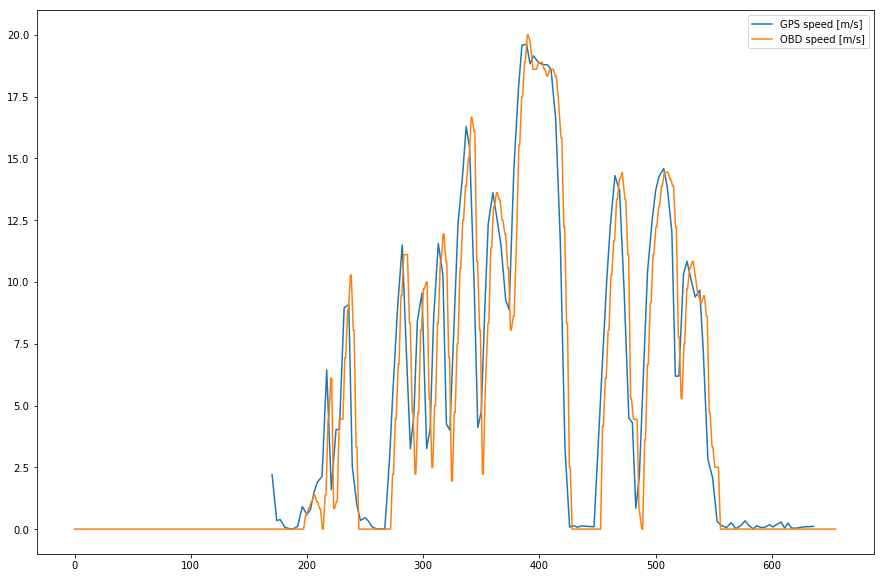

In [9]:
gps_speeds = [
    gps[i+1].distance_2d(gps[i]) / (gps[i+1].time.timestamp() - gps[i].time.timestamp())
    for i in range(len(gps)-1)
    ]

plt.figure(figsize=(15,10))
plt.plot(
    [pt.time.timestamp()-vehicle_start_time for pt in gps[:-1]],
    gps_speeds, label="GPS speed [m/s]")
plt.plot(vehicle_times,
         # convert km/h -> m/s
         vehicle["Speed"] * 1/3.6,
         label="OBD speed [m/s]")
plt.legend()

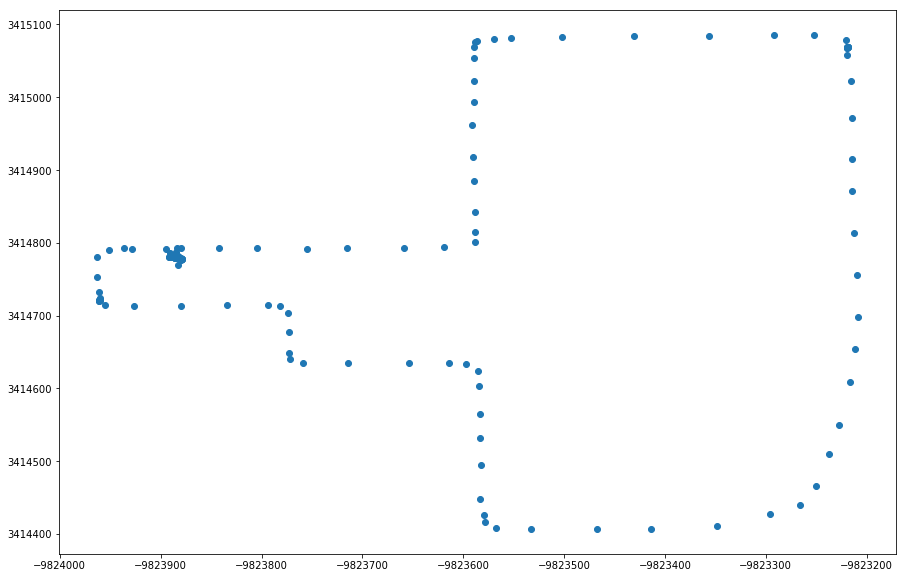

In [10]:
plt.figure(figsize=(15,10))
plt.plot(
    [lon_to_dist*pt.longitude for pt in gps],
    [lat_to_dist*pt.latitude for pt in gps],
    "o"
  )

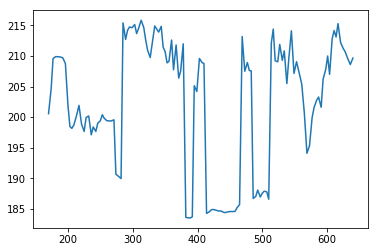

In [11]:
plt.plot(
    [pt.time.timestamp()-vehicle_start_time for pt in gps],
    [pt.elevation for pt in gps],
    )

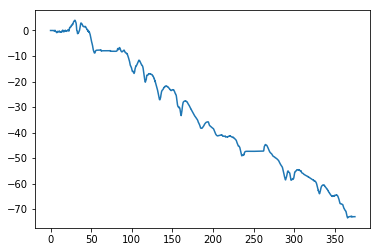

In [18]:
# integrate up acceleration to get another estimate of speed
acc_speed = 0
acc_time = acceleration["Time (s)"]
lin_acc = acceleration["Linear Acceleration y (m/s^2)"]
acc_speeds = []
for i in range(len(acceleration)-1):
    time_interval = acc_time[i+1] - acc_time[i]
    acc_speed = acc_speed + time_interval * lin_acc[i] 
    acc_speeds.append(acc_speed)

plt.plot(acc_time[:-1], acc_speeds)